In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import ttest_ind
from scipy.stats import shapiro, anderson, kstest, norm

#data = pd.read_csv('data/wnba_train_over_under_data.csv')
df= pd.read_csv('data/wnba_train_regression.csv')
OU = df['OU Result']
df.drop(['OU Result'], axis=1, inplace=True)
print(df.describe())
class_counts = OU.value_counts()
print(class_counts)

# Residuals

# Print point
df["Difference"] = df["Points"] - df["L10 Median"]
print(df["Difference"])
print(df.head())

print(df[df["Difference"] > 5])
print(df[df["Difference"] < 5])


       L10 Median  Relative Strength  Minutes Diff   Rest Days    Recent T  \
count  204.000000         204.000000    204.000000  204.000000  204.000000   
mean    15.470588         161.447049     31.603922    2.602941    0.060274   
std      4.688747           5.804757      3.680381    1.061735    1.088751   
min      4.000000         149.863636     20.800000    1.000000   -4.032996   
25%     12.000000         157.225000     29.600000    2.000000   -0.600584   
50%     16.000000         163.022727     32.000000    2.000000    0.080332   
75%     19.000000         165.364996     34.000000    3.000000    0.728243   
max     32.000000         173.118881     40.800000    6.000000    3.152963   

       Opponent PPG      My PPG     P value      Points        Line  
count    204.000000  204.000000  204.000000  204.000000  204.000000  
mean      80.352331   81.094718    0.512494   15.254902   15.696078  
std        3.926414    3.672573    0.274296    7.421426    3.737809  
min       72.5000

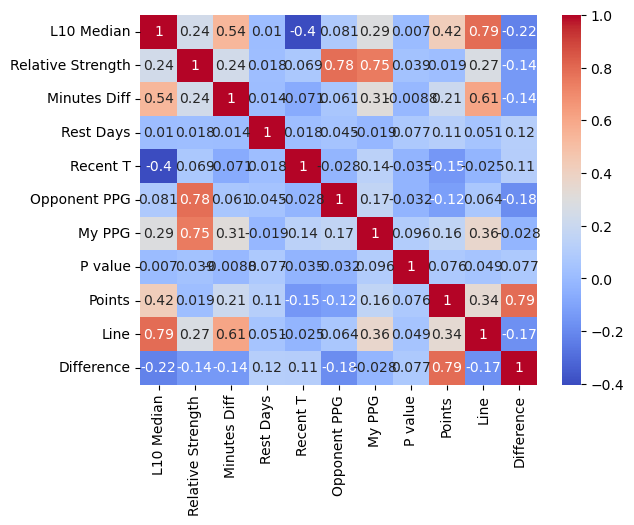

In [5]:
# Correlation matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [8]:

# Perform independent samples t-test
# Statitical difference between home and away games avarage?
points_home_0 = df[df["Rest Days"] != 1]["Difference"].values
points_home_1 = df[df["Rest Days"] == 1]["Difference"].values
print(points_home_0)
print(points_home_1)
t_stat, p_value = ttest_ind(np.array(points_home_0), np.array(points_home_1))
print(t_stat)
print(p_value)



# Kolmogorov-Smirnov Test
data = np.array(df['Difference'])
kstest_stat, kstest_p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
print(f'Kolmogorov-Smirnov Test: Statistic={kstest_stat}, p-value={kstest_p}')
if kstest_p > 0.05:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")

# Residuals are roughly normally distributed, but p = 0.19


"""




print(mean_absolute_error(df['Points'], df['Line']))

# Plot the difference against Rest Days
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Rest Days', y='Difference')
plt.title('Difference between L10 Median and Points vs Rest Days')
plt.xlabel('Rest Days')
plt.ylabel('Difference (L10 Median - Points)')
plt.show()

# Calculate the correlation between Rest Days and Difference
correlation = df['My PPG'].corr(df['Difference'])
print(f"Correlation between Rest Days and Difference (L10 Median - Points): {correlation}")

# Basic info and statistics
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualizations
# Histograms
df.hist(bins=30, figsize=(10, 10))
plt.show()

# Boxplots
df.boxplot(column=['Points', 'Minutes Diff', 'Opponent PPG', 'Rest Days'], figsize=(10, 6))
plt.show()


# Scatter plots


sns.pairplot(df, x_vars=['Points', 'Minutes Diff', 'Rest Days', 'Recent T'], y_vars='OU Result', height=5, aspect=0.8)
plt.show()

# Bar plot for the categorical variable 'Home'
sns.barplot(x='Home', y='OU Result', data=df)
plt.show()
"""

-0.050917644583048254
0.9594414592549769
Kolmogorov-Smirnov Test: Statistic=0.07474976945055967, p-value=0.19442689319141682
Sample looks Gaussian (fail to reject H0)


'\n\n\nprint(mean_absolute_error(df[\'Points\'], df[\'Line\']))\n\n# Plot the difference against Rest Days\nplt.figure(figsize=(10, 6))\nsns.scatterplot(data=df, x=\'Rest Days\', y=\'Difference\')\nplt.title(\'Difference between L10 Median and Points vs Rest Days\')\nplt.xlabel(\'Rest Days\')\nplt.ylabel(\'Difference (L10 Median - Points)\')\nplt.show()\n\n# Calculate the correlation between Rest Days and Difference\ncorrelation = df[\'My PPG\'].corr(df[\'Difference\'])\nprint(f"Correlation between Rest Days and Difference (L10 Median - Points): {correlation}")\n\n# Basic info and statistics\nprint(df.info())\nprint(df.describe())\n\n# Check for missing values\nprint(df.isnull().sum())\n\n# Visualizations\n# Histograms\ndf.hist(bins=30, figsize=(10, 10))\nplt.show()\n\n# Boxplots\ndf.boxplot(column=[\'Points\', \'Minutes Diff\', \'Opponent PPG\', \'Rest Days\'], figsize=(10, 6))\nplt.show()\n\n\n# Scatter plots\n\n\nsns.pairplot(df, x_vars=[\'Points\', \'Minutes Diff\', \'Rest Days\', 

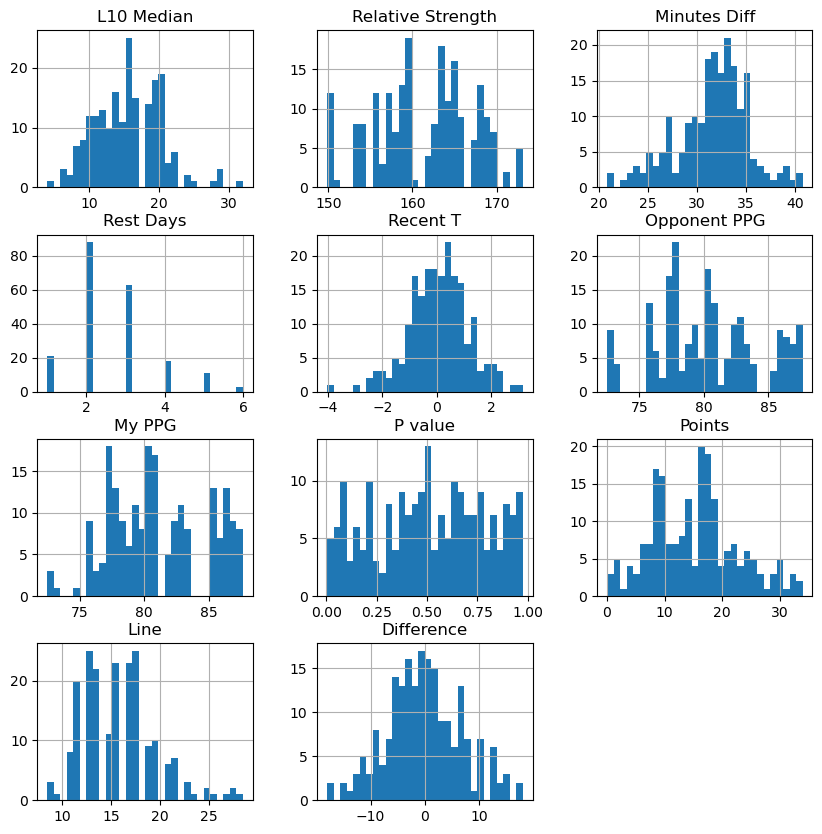

In [9]:
# Histograms
df.hist(bins=30, figsize=(10, 10))
plt.show()